In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
DF = pd.read_csv('data.csv')
print(DF.shape,DF.columns,DF.dtypes)
DF.head()

(3314, 28) Index(['Unnamed: 0', 'Price Hub', 'Trade Date', 'Delivery Start Date',
       'Delivery End Date', 'High Price $/MWh', 'Low Price $/MWh',
       'Wtd Avg Price $/MWh', 'Change', 'Daily Volume MWh', 'Number of Trades',
       'Number of Companies', 'date_x', 'DNI', 'Temperature', 'DHI',
       'Pressure', 'Relative Humidity', 'Wind Speed', 'date_y', 'Date_x',
       'Date_y', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype='object') Unnamed: 0               int64
Price Hub               object
Trade Date              object
Delivery Start Date     object
Delivery End Date       object
High Price $/MWh       float64
Low Price $/MWh        float64
Wtd Avg Price $/MWh    float64
Change                 float64
Daily Volume MWh         int64
Number of Trades         int64
Number of Companies      int64
date_x                  object
DNI                    float64
Temperature            float64
DHI                    float64
Pressure               float64
Relati

,Unnamed: 0,Price Hub,Trade Date,Delivery Start Date,Delivery End Date,High Price $/MWh,Low Price $/MWh,Wtd Avg Price $/MWh,Change,Daily Volume MWh,...,Wind Speed,date_y,Date_x,Date_y,Open,High,Low,Close,Adj Close,Volume
0,0,PJM West,2001-01-02,2001-01-03,2001-01-03,65.5000,64.5000,65.0000,nan,1600,...,908.8960,2001-01-02,2001-01-02,2001-01-02,1320.2800,1320.2800,1276.0500,1283.2700,1283.2700,1129400000.0000
1,1,PJM West,2001-01-03,2001-01-04,2001-01-04,63.0000,59.5000,61.2500,-3.7500,3200,...,911.6792,2001-01-03,2001-01-03,2001-01-03,1283.2700,1347.7600,1274.6200,1347.5601,1347.5601,1880700000.0000
2,2,PJM West,2001-01-04,2001-01-05,2001-01-05,60.0000,58.5000,59.1200,-2.1300,4800,...,839.5736,2001-01-04,2001-01-04,2001-01-04,1347.5601,1350.2400,1329.1400,1333.3400,1333.3400,2131000000.0000
3,3,PJM West,2001-01-08,2001-01-09,2001-01-09,59.5000,59.5000,59.5000,0.3800,800,...,537.5872,2001-01-08,2001-01-08,2001-01-08,1298.3500,1298.3500,1276.2900,1295.8600,1295.8600,1115500000.0000
4,4,PJM West,2001-01-09,2001-01-10,2001-01-10,58.0000,55.5000,56.6100,-2.8900,5600,...,1128.6156,2001-01-09,2001-01-09,2001-01-09,1295.8600,1311.7200,1295.1400,1300.8000,1300.8000,1191300000.0000


In [3]:
DF = DF.drop(['date_x','date_y','Date_x','Date_y'],axis  = 1)
df = DF.drop(['Price Hub','Delivery Start Date','Delivery End Date'],axis = 1)
df.head()

,Unnamed: 0,Trade Date,High Price $/MWh,Low Price $/MWh,Wtd Avg Price $/MWh,Change,Daily Volume MWh,Number of Trades,Number of Companies,DNI,...,DHI,Pressure,Relative Humidity,Wind Speed,Open,High,Low,Close,Adj Close,Volume
0,0,2001-01-02,65.5000,64.5000,65.0000,nan,1600,2,2,68797.3941,...,10899.5375,333825.4860,24807.8851,908.8960,1320.2800,1320.2800,1276.0500,1283.2700,1283.2700,1129400000.0000
1,1,2001-01-03,63.0000,59.5000,61.2500,-3.7500,3200,4,2,68287.3104,...,9436.2613,331530.1973,25660.5908,911.6792,1283.2700,1347.7600,1274.6200,1347.5601,1347.5601,1880700000.0000
2,2,2001-01-04,60.0000,58.5000,59.1200,-2.1300,4800,6,4,42744.5558,...,12108.2430,329297.6083,26548.0073,839.5736,1347.5601,1350.2400,1329.1400,1333.3400,1333.3400,2131000000.0000
3,3,2001-01-08,59.5000,59.5000,59.5000,0.3800,800,1,2,23221.8513,...,13144.1723,327948.2916,30604.1390,537.5872,1298.3500,1298.3500,1276.2900,1295.8600,1295.8600,1115500000.0000
4,4,2001-01-09,58.0000,55.5000,56.6100,-2.8900,5600,7,6,74552.0563,...,10884.7411,329242.5842,24703.9764,1128.6156,1295.8600,1311.7200,1295.1400,1300.8000,1300.8000,1191300000.0000


In [4]:
df.dtypes
DF = DF.drop(['Unnamed: 0'],axis=1)
DF.head()

,Price Hub,Trade Date,Delivery Start Date,Delivery End Date,High Price $/MWh,Low Price $/MWh,Wtd Avg Price $/MWh,Change,Daily Volume MWh,Number of Trades,...,DHI,Pressure,Relative Humidity,Wind Speed,Open,High,Low,Close,Adj Close,Volume
0,PJM West,2001-01-02,2001-01-03,2001-01-03,65.5000,64.5000,65.0000,nan,1600,2,...,10899.5375,333825.4860,24807.8851,908.8960,1320.2800,1320.2800,1276.0500,1283.2700,1283.2700,1129400000.0000
1,PJM West,2001-01-03,2001-01-04,2001-01-04,63.0000,59.5000,61.2500,-3.7500,3200,4,...,9436.2613,331530.1973,25660.5908,911.6792,1283.2700,1347.7600,1274.6200,1347.5601,1347.5601,1880700000.0000
2,PJM West,2001-01-04,2001-01-05,2001-01-05,60.0000,58.5000,59.1200,-2.1300,4800,6,...,12108.2430,329297.6083,26548.0073,839.5736,1347.5601,1350.2400,1329.1400,1333.3400,1333.3400,2131000000.0000
3,PJM West,2001-01-08,2001-01-09,2001-01-09,59.5000,59.5000,59.5000,0.3800,800,1,...,13144.1723,327948.2916,30604.1390,537.5872,1298.3500,1298.3500,1276.2900,1295.8600,1295.8600,1115500000.0000
4,PJM West,2001-01-09,2001-01-10,2001-01-10,58.0000,55.5000,56.6100,-2.8900,5600,7,...,10884.7411,329242.5842,24703.9764,1128.6156,1295.8600,1311.7200,1295.1400,1300.8000,1300.8000,1191300000.0000


In [5]:
DF.head()

,Price Hub,Trade Date,Delivery Start Date,Delivery End Date,High Price $/MWh,Low Price $/MWh,Wtd Avg Price $/MWh,Change,Daily Volume MWh,Number of Trades,...,DHI,Pressure,Relative Humidity,Wind Speed,Open,High,Low,Close,Adj Close,Volume
0,PJM West,2001-01-02,2001-01-03,2001-01-03,65.5000,64.5000,65.0000,nan,1600,2,...,10899.5375,333825.4860,24807.8851,908.8960,1320.2800,1320.2800,1276.0500,1283.2700,1283.2700,1129400000.0000
1,PJM West,2001-01-03,2001-01-04,2001-01-04,63.0000,59.5000,61.2500,-3.7500,3200,4,...,9436.2613,331530.1973,25660.5908,911.6792,1283.2700,1347.7600,1274.6200,1347.5601,1347.5601,1880700000.0000
2,PJM West,2001-01-04,2001-01-05,2001-01-05,60.0000,58.5000,59.1200,-2.1300,4800,6,...,12108.2430,329297.6083,26548.0073,839.5736,1347.5601,1350.2400,1329.1400,1333.3400,1333.3400,2131000000.0000
3,PJM West,2001-01-08,2001-01-09,2001-01-09,59.5000,59.5000,59.5000,0.3800,800,1,...,13144.1723,327948.2916,30604.1390,537.5872,1298.3500,1298.3500,1276.2900,1295.8600,1295.8600,1115500000.0000
4,PJM West,2001-01-09,2001-01-10,2001-01-10,58.0000,55.5000,56.6100,-2.8900,5600,7,...,10884.7411,329242.5842,24703.9764,1128.6156,1295.8600,1311.7200,1295.1400,1300.8000,1300.8000,1191300000.0000


(3314, 23)
(3314,)
(3314,)


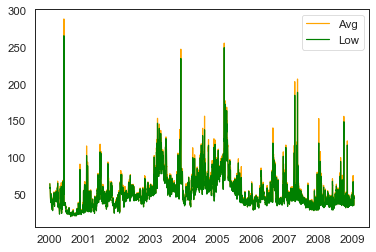

In [6]:
X = DF.values
print(X.shape)
date_range = pd.date_range(start = '1/1/2000', end = '1/26/2009')
dates = X[:,1]
prices = X[:,6]
low_prices = X[:,5]
high_prices = X[:,4]
print(prices.shape)
order_date = date_range.values
print(order_date.shape)
plt.plot(order_date,prices,color='orange',label='Avg')
plt.plot(order_date,low_prices,color = 'green',label = 'Low')
#plt.plot(order_date,high_prices,color = 'red',label = 'High')
plt.legend(loc = 'best')
plt.show()

In [7]:
X = df.values
df.dtypes

Unnamed: 0               int64
Trade Date              object
High Price $/MWh       float64
Low Price $/MWh        float64
Wtd Avg Price $/MWh    float64
Change                 float64
Daily Volume MWh         int64
Number of Trades         int64
Number of Companies      int64
DNI                    float64
Temperature            float64
DHI                    float64
Pressure               float64
Relative Humidity      float64
Wind Speed             float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Adj Close              float64
Volume                 float64
dtype: object

In [8]:
df = df.drop(['Unnamed: 0'],axis = 1)
df.dtypes

Trade Date              object
High Price $/MWh       float64
Low Price $/MWh        float64
Wtd Avg Price $/MWh    float64
Change                 float64
Daily Volume MWh         int64
Number of Trades         int64
Number of Companies      int64
DNI                    float64
Temperature            float64
DHI                    float64
Pressure               float64
Relative Humidity      float64
Wind Speed             float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Adj Close              float64
Volume                 float64
dtype: object

In [9]:
df['Trade Date'] = pd.to_datetime(df['Trade Date'], format ="%Y-%m-%d")

In [10]:
df_new = df.dropna(subset = [i for i in df.columns])
df_new = df.fillna(df.mean())
df_new.head()

,Trade Date,High Price $/MWh,Low Price $/MWh,Wtd Avg Price $/MWh,Change,Daily Volume MWh,Number of Trades,Number of Companies,DNI,Temperature,DHI,Pressure,Relative Humidity,Wind Speed,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,65.5000,64.5000,65.0000,0.0038,1600,2,2,68797.3941,-2032.7555,10899.5375,333825.4860,24807.8851,908.8960,1320.2800,1320.2800,1276.0500,1283.2700,1283.2700,1129400000.0000
1,2001-01-03,63.0000,59.5000,61.2500,-3.7500,3200,4,2,68287.3104,-1686.3585,9436.2613,331530.1973,25660.5908,911.6792,1283.2700,1347.7600,1274.6200,1347.5601,1347.5601,1880700000.0000
2,2001-01-04,60.0000,58.5000,59.1200,-2.1300,4800,6,4,42744.5558,-1077.9615,12108.2430,329297.6083,26548.0073,839.5736,1347.5601,1350.2400,1329.1400,1333.3400,1333.3400,2131000000.0000
3,2001-01-08,59.5000,59.5000,59.5000,0.3800,800,1,2,23221.8513,-683.1145,13144.1723,327948.2916,30604.1390,537.5872,1298.3500,1298.3500,1276.2900,1295.8600,1295.8600,1115500000.0000
4,2001-01-09,58.0000,55.5000,56.6100,-2.8900,5600,7,6,74552.0563,-1418.5120,10884.7411,329242.5842,24703.9764,1128.6156,1295.8600,1311.7200,1295.1400,1300.8000,1300.8000,1191300000.0000


In [11]:
df_new.dtypes

Trade Date             datetime64[ns]
High Price $/MWh              float64
Low Price $/MWh               float64
Wtd Avg Price $/MWh           float64
Change                        float64
Daily Volume MWh                int64
Number of Trades                int64
Number of Companies             int64
DNI                           float64
Temperature                   float64
DHI                           float64
Pressure                      float64
Relative Humidity             float64
Wind Speed                    float64
Open                          float64
High                          float64
Low                           float64
Close                         float64
Adj Close                     float64
Volume                        float64
dtype: object

In [12]:
X = df_new.values

In [13]:
X.shape

(3314, 20)

In [14]:
Y = np.zeros((3314,1))

Y[:,0] = X[:,3]
print(Y[:,0],X[:,3])
print(Y.shape)


[65.   61.25 59.12 ... 46.46 45.8  48.83] [65.0 61.25 59.12 ... 46.46 45.8 48.83]
(3314, 1)


In [15]:
input_feature = X[:,[1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
print(X.shape,input_feature.shape)

(3314, 20) (3314, 18)


In [16]:
input_feature = input_feature.astype('float32')
minscale_x = MinMaxScaler(feature_range=(0,1))
minscale_y = MinMaxScaler(feature_range=(0,1))

In [17]:
input_feature = minscale_x.fit_transform(input_feature)
input_feature[:,0]

array([0.14890128, 0.14070188, 0.13086258, ..., 0.08822565, 0.09150541,
       0.09806494], dtype=float32)

In [18]:
Y = minscale_y.fit_transform(Y)
print(Y[:,0])
print(Y.shape)

[0.167423   0.15347419 0.14555126 ... 0.09846005 0.09600506 0.1072757 ]
(3314, 1)


In [19]:
train_len = int(len(input_feature)*0.85)
test_len = len(input_feature) - train_len

In [20]:
train_X = input_feature[:train_len,:]
test_X = input_feature[train_len:,:]
print(train_X.shape,test_X.shape)

(2816, 18) (498, 18)


In [21]:
train_Y = Y[:train_len,:]
test_Y = Y[train_len:,:]
print(train_Y.shape,test_Y.shape)

(2816, 1) (498, 1)


In [22]:
data = np.zeros((3314,19))
data[:2816,:18] = train_X
data[:2816,18:] = train_Y
data[2816:,:18] = test_X
data[2816:,18:] = test_Y

train_data , test_data = data[:train_len,:],data[train_len:len(data),:]
print(train_data.shape,test_data.shape)

(2816, 19) (498, 19)


In [23]:
def make(data,past = 1):
    X,Y = [],[]
    for i in range(len(data)-past-1):
        a = data[i:(i+past),0:18]
        X.append(a)
        Y.append(data[i+past,18])
    return np.array(X),np.array(Y)

In [24]:
past = 30
X_train , Y_train = make(train_data,past)
X_test , Y_test = make(test_data,past)
print(X_train.shape,X_test.shape)

(2785, 30, 18) (467, 30, 18)


In [25]:
X_train = np.reshape(X_train,(X_train.shape[0],30,18))
X_test = np.reshape(X_test,(X_test.shape[0],30,18))
Y_train = np.array([Y_train]).T
Y_test = np.array([Y_test]).T
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(2785, 30, 18) (467, 30, 18) (2785, 1) (467, 1)


## LSTM models

In [26]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2785 samples, validate on 467 samples
Epoch 1/20





2785/2785 [==============================] - 5s 2ms/step - loss: 0.0169 - val_loss: 0.0059
Epoch 2/20
2785/2785 [==============================] - 2s 655us/step - loss: 0.0072 - val_loss: 0.0031
Epoch 3/20
2785/2785 [==============================] - 2s 637us/step - loss: 0.0055 - val_loss: 0.0031
Epoch 4/20
2785/2785 [==============================] - 2s 624us/step - loss: 0.0046 - val_loss: 0.0029
Epoch 5/20
2785/2785 [==============================] - 2s 843us/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/20
2785/2785 [==============================] - 2s 649us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/20
2785/2785 [==============================] - 3s 1ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 8

In [27]:
model.save_weights('weights.h5')

In [28]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [29]:
train_predict = minscale_y.inverse_transform(train_pred)
Y_train = minscale_y.inverse_transform(Y_train)
test_predict = minscale_y.inverse_transform(test_pred)
Y_test = minscale_y.inverse_transform(Y_test)

In [30]:
print(train_pred.shape,test_pred.shape)
rmse_train = mean_squared_error(Y_train[:,0],train_predict[:,0])
rmse_absolute_train = mean_absolute_error(Y_train,train_predict)
rmse_test = mean_squared_error(Y_test,test_predict)
rmse_absolute_test = mean_absolute_error(Y_test,test_predict)
print("Train root mean square error", np.sqrt(rmse_train))
print("Train absolute error",rmse_absolute_train)
print("Test root mean square error",np.sqrt(rmse_test))
print("Test absolute error",rmse_absolute_test)

(2785, 1) (467, 1)
Train root mean square error 12.518183038575403
Train absolute error 8.148153889445059
Test root mean square error 11.747577291919768
Test absolute error 7.403125770781229


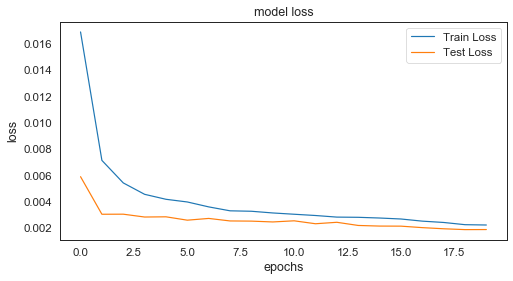

In [34]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

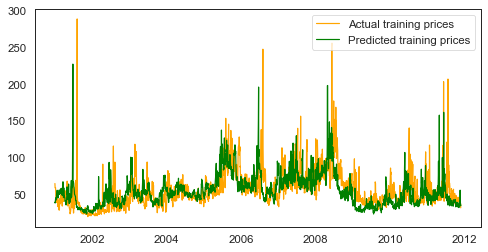

In [36]:
plt.figure(figsize=(8,4))
plt.plot(X[:2785,0],X[:2785,3],color='orange',label='Actual training prices')
plt.plot(X[:2785,0],train_predict[:,0],'green',label='Predicted training prices')
plt.legend(loc='best')
plt.show()

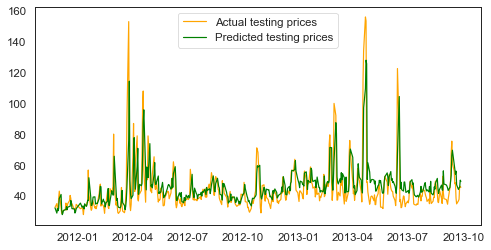

In [37]:
plt.figure(figsize=(8,4))
plt.plot(X[2785:3252,0],Y_test[:,0],color='orange',label='Actual testing prices')
plt.plot(X[2785:3252,0],test_predict[:,0],'green',label='Predicted testing prices')
plt.legend(loc='best')
plt.show()